In [1]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [2]:
# Creating the Pathlib PATH objects
train_path = Path("train")
test_path = Path("test")

In [3]:
# Getting Image Paths
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]


['train\\angry\\Training_10118481.jpg',
 'train\\angry\\Training_10120469.jpg',
 'train\\angry\\Training_10131352.jpg',
 'train\\angry\\Training_10161559.jpg',
 'train\\angry\\Training_1021836.jpg',
 'train\\angry\\Training_10269675.jpg',
 'train\\angry\\Training_10278738.jpg',
 'train\\angry\\Training_10290703.jpg',
 'train\\angry\\Training_10295477.jpg',
 'train\\angry\\Training_10315441.jpg']

In [6]:
# Getting their respective labels

def get_label(image_path):
  return image_path.split("\\")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry']

In [7]:
from sklearn.preprocessing import LabelEncoder

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [8]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [9]:
from sklearn.model_selection import train_test_split

Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)


In [10]:
# Compute class weights

classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.8074741, 1: 16.074184, 2: 1.7434825, 3: 1.0, 4: 1.4712113, 5: 1.4898239, 6: 2.3002124}


In [11]:
# Function used for Transformation
def load(image , label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image , channels = 3)
  return image , label

In [12]:
# Define IMAGE SIZE and BATCH SIZE
IMG_SIZE = 96
BATCH_SIZE = 32

# Basic Information
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)
])

# Data Augmentation 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [13]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths, labels, train = True):
  image_paths = tf.convert_to_tensor(paths)
  labels = tf.convert_to_tensor(labels)

  image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
  label_dataset = tf.data.Dataset.from_tensor_slices(labels)

  dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

  dataset = dataset.map(lambda image , label : load(image , label))
  dataset = dataset.map(lambda image , label : (resize(image), label) , num_parallel_calls = AUTOTUNE)
  dataset = dataset.shuffle(1000)
  dataset = dataset.batch(BATCH_SIZE)

  if train:
    dataset = dataset.map(lambda image, label: (data_augmentation(image), label), num_parallel_calls = AUTOTUNE)

  dataset = dataset.repeat()
  return dataset

In [14]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

Wall time: 733 ms
(32, 96, 96, 3)
(32, 7)


happy


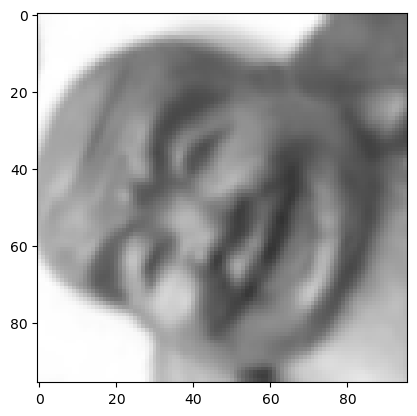

In [15]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [16]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

Wall time: 44.9 ms
(32, 96, 96, 3)
(32, 7)


In [17]:
# Building EfficientNet model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96,96,3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation ='softmax')
])

model.summary()

31790344/31790344 [==============================] - 29s 1us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 7,882,249
No

In [18]:
# Compiling our model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [19]:
# Train the model - Phase 1
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=12,
    validation_data = val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/12
672/672 [==============================] - 1104s 2s/step - loss: 3.0211 - accuracy: 0.3466 - precision: 0.6254 - recall: 0.1226 - val_loss: 1.4238 - val_accuracy: 0.4858 - val_precision: 0.7915 - val_recall: 0.2267
Epoch 2/12
672/672 [==============================] - 1160s 2s/step - loss: 2.5669 - accuracy: 0.4563 - precision: 0.6946 - recall: 0.2343 - val_loss: 1.2674 - val_accuracy: 0.5124 - val_precision: 0.7755 - val_recall: 0.2800
Epoch 3/12
672/672 [==============================] - 1113s 2s/step - loss: 2.3984 - accuracy: 0.4844 - precision: 0.6908 - recall: 0.2695 - val_loss: 1.2910 - val_accuracy: 0.5184 - val_precision: 0.7106 - val_recall: 0.3165
Epoch 4/12
672/672 [==============================] - 1111s 2s/step - loss: 2.3210 - accuracy: 0.5032 - precision: 0.7003 - recall: 0.2958 - val_loss: 1.2636 - val_accuracy: 0.5321 - val_precision: 0.7411 - val_recall: 0.3206
Epoch 5/12
672/672 [==============================] - 1102s 2s/step - loss: 2.2124 - accuracy: 0

In [20]:
model.layers[0].trainable = False

In [21]:
# Define the callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 181,255
Non-trainable params: 7,768,569
______________________________________

In [23]:
# Train the model - Phase 2
h1 = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data = val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/8
672/672 [==============================] - ETA: 0s - loss: 1.9168 - accuracy: 0.5747 - precision: 0.7242 - recall: 0.4107
Epoch 1: val_loss improved from inf to 1.19014, saving model to best_weights.h5
672/672 [==============================] - 924s 1s/step - loss: 1.9168 - accuracy: 0.5747 - precision: 0.7242 - recall: 0.4107 - val_loss: 1.1901 - val_accuracy: 0.5607 - val_precision: 0.6990 - val_recall: 0.4156
Epoch 2/8
672/672 [==============================] - ETA: 0s - loss: 1.8248 - accuracy: 0.5944 - precision: 0.7399 - recall: 0.4442
Epoch 2: val_loss did not improve from 1.19014
672/672 [==============================] - 970s 1s/step - loss: 1.8248 - accuracy: 0.5944 - precision: 0.7399 - recall: 0.4442 - val_loss: 1.2143 - val_accuracy: 0.5526 - val_precision: 0.6873 - val_recall: 0.3952
Epoch 3/8
672/672 [==============================] - ETA: 0s - loss: 1.7951 - accuracy: 0.6016 - precision: 0.7398 - recall: 0.4453
Epoch 3: val_loss improved from 1.19014 to 1.1145

In [25]:
import pandas as pd

r1 = pd.DataFrame(h1.history)
r1['Epochs'] = h1.epoch
r1.tail()

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,Epochs
3,1.784302,0.602633,0.731002,0.454161,1.145278,0.569475,0.685543,0.445871,3
4,1.767205,0.602726,0.732673,0.450905,1.141661,0.577148,0.703232,0.431083,4
5,1.720171,0.612168,0.743926,0.469975,1.086129,0.593471,0.708430,0.467773,5
6,1.687903,0.619378,0.742438,0.482953,1.092772,0.585658,0.701081,0.479353,6
7,1.702393,0.614168,0.741348,0.475278,1.099819,0.605190,0.692989,0.512974,7


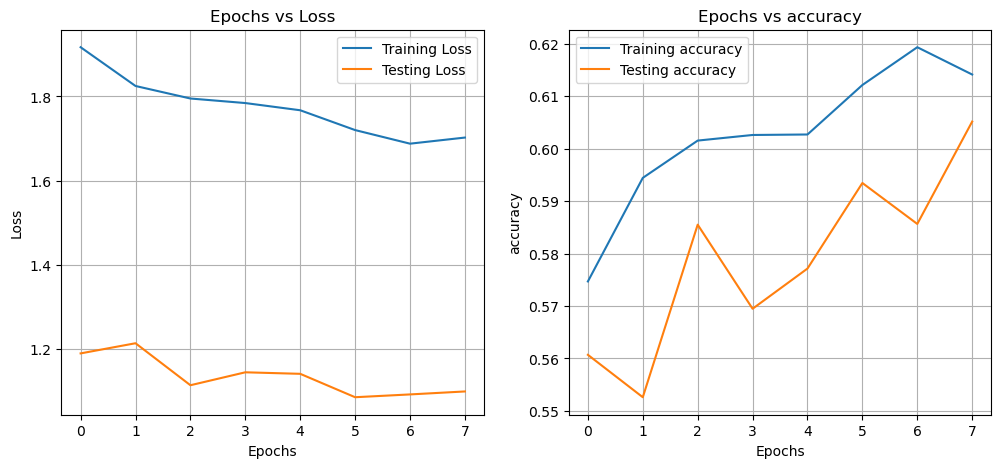

In [26]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(r1['Epochs'],r1['loss'],label='Training Loss')
plt.plot(r1['Epochs'],r1['val_loss'],label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(r1['Epochs'],r1['accuracy'],label='Training accuracy')
plt.plot(r1['Epochs'],r1['val_accuracy'],label='Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Epochs vs accuracy')
plt.grid()
plt.legend()

plt.savefig("abc.png")
plt.show()

In [29]:
model.trainable = True
model.load_weights("best_weights.h5")

In [30]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image , channels = 3)
  image = tf.image.resize(image , [96 , 96] , method="bilinear")
  return image , label

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [31]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


angry


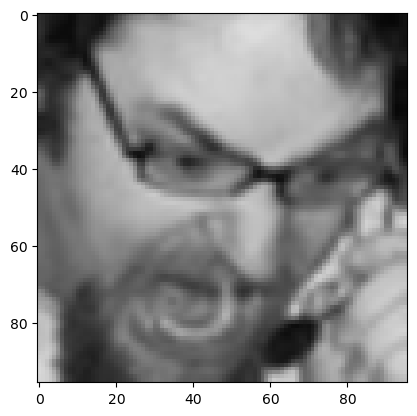

In [32]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [41]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : ", acc)
print(" Testing Precision ", prec)
print(" Testing Recall ", rec)

225/225 [==============================] - 61s 271ms/step - loss: 1.0930 - accuracy: 0.5938 - precision: 0.7002 - recall: 0.4631
 Testing Acc :  0.5937587022781372
 Testing Precision  0.7002317309379578
 Testing Recall  0.46308162808418274


In [43]:
import pickle
filename ="FacialExpressionModel.h5"
pickle.dump(model,open(filename,"wb"))

In [40]:
# from tensorflow.keras.models import save_model

# save_model(model,"FacialExpressionModel.h5")

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [38]:
# Save Model
# model.save("FacialExpressionModel.h5")

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [46]:
# Save Label Encoder

def save_object(obj , name):
  pickle_obj = open(f"{name}.pck","wb")
  pickle.dump(obj, pickle_obj)
  pickle_obj.close()

In [47]:
save_object(Le, "LabelEncoder")
